In [1]:
import numpy as np
import pandas as pd 
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import SGD, Adam
import bz2
import csv
from sklearn.metrics import roc_auc_score

# Data Exploration

In [2]:
# Load the training data 
df_train = pd.read_csv('train.ft.txt.bz2', delimiter='\t', header=None, names=['text', 'label']).sample(200000)

In [6]:
# Display basic information about the dataset
df_train.head()

,text,label
2205514,__label__1 Disappointment: I was expecting it ...,NaN
1212195,__label__1 save your money: this movie is terr...,NaN
2548056,__label__2 A Secular View of Martin Luther: Th...,NaN
1008846,__label__2 Telma Vegetable: Everyone always ha...,NaN
2017133,__label__2 definitely an XL!: Turned out that ...,NaN


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 2205514 to 2346240
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    200000 non-null  object 
 1   label   0 non-null       float64
dtypes: float64(1), object(1)
memory usage: 4.6+ MB


In [3]:
# Load the test data df_test
df_test = pd.read_csv('test.ft.txt.bz2', delimiter='\t', header=None, names=['text', 'label']).sample(50000)

In [8]:
df_test.head()

,text,label
202636,__label__1 Don't waste your money.: Generally ...,NaN
10286,__label__2 Engaging little ones & peeking inte...,NaN
92629,__label__1 waste of time: This video was a com...,NaN
309495,"__label__2 King of the ""Armageddon"" ending: Ye...",NaN
278719,__label__1 NOT MAC COMPATIBLE!!!!!!!!!: This m...,NaN


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 202636 to 76510
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    50000 non-null  object 
 1   label   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


# Data Preprocessing

In [15]:
# Split the data into labels and texts
train_texts = df_train['text'].values
train_labels = df_train['label'].apply(lambda x: 1 if x == '__label__2' else 0).values  # Assuming binary sentiment
test_texts = df_test['text'].values
test_labels = df_test['label'].apply(lambda x: 1 if x == '__label__2' else 0).values  # Assuming binary sentiment

In [16]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [17]:
# Pad sequences
maxlen = 100
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)

In [19]:
# Display the shape of the data
print(X_train.shape)
print(X_test.shape)

(200000, 100)
(50000, 100)


# Model Building

In [21]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [22]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [24]:
# Train the model
history = model.fit(X_train, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 312s 123ms/step - accuracy: 0.9987 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 1.0397e-06
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 305s 122ms/step - accuracy: 1.0000 - loss: 7.7964e-07 - val_accuracy: 1.0000 - val_loss: 2.5976e-07
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 305s 122ms/step - accuracy: 1.0000 - loss: 2.0320e-07 - val_accuracy: 1.0000 - val_loss: 7.5836e-08
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 309s 124ms/step - accuracy: 1.0000 - loss: 5.9692e-08 - val_accuracy: 1.0000 - val_loss: 2.2793e-08
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 313s 125ms/step - accuracy: 1.0000 - loss: 1.7966e-08 - val_accuracy: 1.0000 - val_loss: 7.0025e-09


# Model Evaluation

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step


In [29]:
# Calculate metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


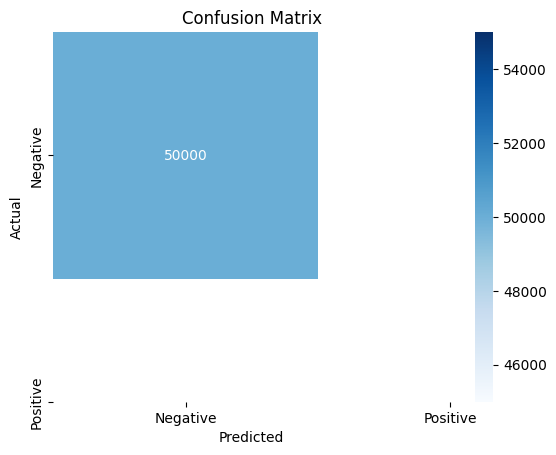

In [30]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Experimentation

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [32]:
num_experiments = 5
results = []

for i in range(num_experiments):
    print(f"Experiment {i+1}/{num_experiments}")

Experiment 1/5
Experiment 2/5
Experiment 3/5
Experiment 4/5
Experiment 5/5


In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, test_labels)
    
    # Store the results
results.append({
        'experiment': i+1,
        'loss': loss,
        'accuracy': accuracy,
        'history': history.history
    })

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 1.0000 - loss: 7.0016e-09


# Results Analysis

In [37]:
# Results Analysis
for result in results:
    print(f"Experiment {result['experiment']}:")
    print("Test set loss:", result['loss'])
    print("Test set accuracy:", result['accuracy'])
    # Further analysis and discussion of the results can be done here

Experiment 5:
Test set loss: 7.001460300415374e-09
Test set accuracy: 1.0
